# Transient optical laser reflectivity measurement: finding FEL and OL time overlap

Transient optical laser reflectivity is a technique to determine the temporal overlap between the FEL and the optical laser (OL). The FEL is pumping a large band gap material (usually a 1 micrometer thick Si$_3$N$_4$ membrane) and the OL, spatially overlaped with the FEL, is reflected off the sample. The incoming ($I_0$) and  reflected ($I_r$) laser beams are monitored by photodiodes. The FEL pump alters the electronic properties of the material, which in turn modifies the reflectivity. By varying the delay between OL and FEL through the scanning of the optical delay line, the transient response of the material is measured and the exact time overlap between the two beams can be extracted.

To increase the signal to noise ratio, pumped and unpumped signals acquired closely in time are compared. The reflectivity is then defined as:

$\Delta R [\%] = 100\times(\frac{R(pumped)}{R(unpumped)} - 1)$, with $R = I_r / I_0$

In the `toolbox_scs`, there is a convenience function `reflectivity` that allows the quick calculation of $\Delta R$. It performs binning along the motor position axis and sorts the data according to the bunch pattern and the sequence of pumped, unpumped.

Below is an example, where $I_0$ ($I_r$) is measured a by photodiode on the Fast ADC channel 5 (channel 3), respectively. The pump FEL is set at half the repetition rate of the OL, to have alternating pumped/unpumped/pumped/unpumped/... pulses within each train.

<xarray.Dataset>
Dimensions:                 (delay: 133)
Coordinates:
  * delay                   (delay) float64 228.2 228.2 228.2 ... 229.5 229.5
Data variables:
    FastADC5peaks           (delay) float64 2.009e+05 1.958e+05 ... 1.937e+05
    FastADC3peaks           (delay) float64 7.286e+04 6.932e+04 ... 7.36e+04
    FastADC5peaks_unpumped  (delay) float64 2.007e+05 1.955e+05 ... 1.935e+05
    FastADC3peaks_unpumped  (delay) float64 7.226e+04 6.872e+04 ... 7.293e+04
    PP800_DelayLine_binned  (delay) float64 228.2 228.2 228.2 ... 229.5 229.5
    deltaR                  (delay) float64 0.7039 0.7426 ... 0.8043 0.8176
    deltaR_std              (delay) float64 0.8555 0.9384 ... 0.9011 0.9902
    deltaR_stderr           (delay) float64 0.07418 0.06808 ... 0.09245 0.08032
    counts                  (delay) int64 133 190 114 266 304 ... 114 380 95 152
Attributes:
    runFolder:  /gpfs/exfel/exp/SCS/202201/p002769/raw/r0425

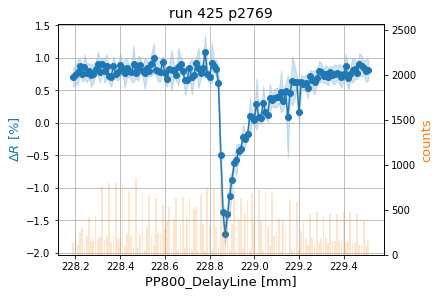

In [1]:
import toolbox_scs as tb
proposal, runNB = 2769, 425
fields = ['FastADC5raw', 'FastADC3raw', 'PP800_DelayLine', 'BAM1932S']
run, ds = tb.load(proposal, runNB, fields)

refl = tb.reflectivity(ds, Iokey='FastADC5peaks', Irkey='FastADC3peaks',
                       delaykey='PP800_DelayLine',
                       binWidth=0.01, plot=True)
refl

The output is an `xarray.Dataset` that contains the binned `deltaR`, its standard deviation and standard error, as well as the delay line position bins and the counts per bin.

One can also convert the motor position axis in mm into temporal axis in ps. For this, the argument `positionToDelay` can be used, in combination with `origin` which gives the motor position for time zero and `invert`, which gives the sign of time axis relative to the motor axis. In this case, `binWidth` is the width in picosecond, and the output has a new coordinate `delay_ps`.

<xarray.Dataset>
Dimensions:                 (delay: 133)
Coordinates:
  * delay                   (delay) float64 228.2 228.2 228.2 ... 229.5 229.5
Data variables:
    FastADC5peaks           (delay) float64 2.009e+05 1.958e+05 ... 1.937e+05
    FastADC3peaks           (delay) float64 7.286e+04 6.932e+04 ... 7.36e+04
    FastADC5peaks_unpumped  (delay) float64 2.007e+05 1.955e+05 ... 1.935e+05
    FastADC3peaks_unpumped  (delay) float64 7.226e+04 6.872e+04 ... 7.293e+04
    PP800_DelayLine_binned  (delay) float64 228.2 228.2 228.2 ... 229.5 229.5
    deltaR                  (delay) float64 0.7039 0.7426 ... 0.8043 0.8176
    deltaR_std              (delay) float64 0.8555 0.9384 ... 0.9011 0.9902
    deltaR_stderr           (delay) float64 0.07418 0.06808 ... 0.09245 0.08032
    counts                  (delay) int64 133 190 114 266 304 ... 114 380 95 152
Attributes:
    runFolder:  /gpfs/exfel/exp/SCS/202201/p002769/raw/r0425

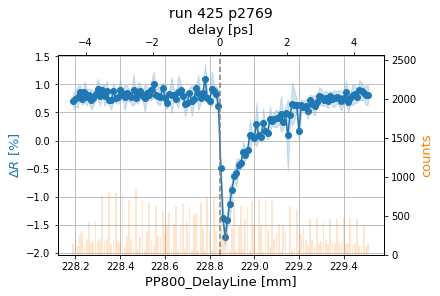

In [2]:
refl = tb.reflectivity(ds, Iokey='FastADC5peaks', Irkey='FastADC3peaks',
                       delaykey='PP800_DelayLine',
                       positionToDelay=True, origin=228.845, invert=False,
                       binWidth=0.01, plot=True)
refl

## Correction by the BAM

The BAM data can be taken into account by calculating the delay from the motor position and adding the BAM values to it:

In [3]:
ds['delay'] = ds['BAM1932S'] + tb.positionToDelay(ds['PP800_DelayLine'], origin=228.845, invert=False)


Once this is done, the new `delay` variable has two dimensions `trainId` and `sa3_pId`, while the OL photodiodes (`FastADC3peaks` and `FastADC5peaks`) have dimensions `trainId` and `ol_pId`. The aligment of the OL pulses to the FEL pulses can be done by shifting the `ol_pId` coordinates:

In [4]:
newds = tb.align_ol_to_fel_pId(ds)
newds

<xarray.Dataset>
Dimensions:            (pulse_slot: 2700, sa3_pId: 38, trainId: 2222)
Coordinates:
  * sa3_pId            (sa3_pId) int64 542 582 622 662 ... 1902 1942 1982 2022
  * trainId            (trainId) uint64 1298104001 1298104002 ... 1298106265
Dimensions without coordinates: pulse_slot
Data variables:
    bunchPatternTable  (trainId, pulse_slot) uint32 2178857 0 2097193 ... 0 0 0
    PP800_DelayLine    (trainId) float64 229.1 229.1 229.1 ... 228.3 228.3 228.3
    BAM1932S           (trainId, sa3_pId) float32 -0.1843975 nan ... nan
    delay              (trainId, sa3_pId) float64 1.444 nan 1.468 ... -3.665 nan
    FastADC3peaks      (trainId, sa3_pId) float64 8.711e+04 ... 5.205e+04
    FastADC5peaks      (trainId, sa3_pId) float64 2.083e+05 ... 1.712e+05
Attributes:
    runFolder:  /gpfs/exfel/exp/SCS/202201/p002769/raw/r0425

When plotting the reflectivity, one can use `units='ps'` to specify the correct units of the bottom axis (by default `units='mm'`).

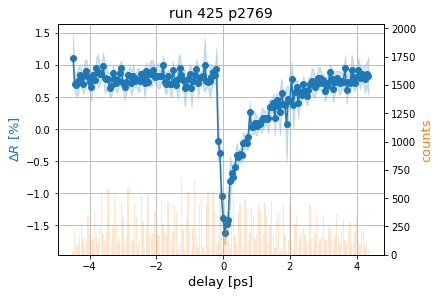

In [6]:
refl = tb.reflectivity(newds, delaykey='delay', units='ps')

The shift in time corresponds to the BAM values, whose average in this run is `newds['BAM1932S'].mean().values = -121.54 fs`.